# HOMEWORK 5

In this homework you are going to implement the **Floyd-Steinberg dithering** algorithm. Dithering, in general, means that we are adding noise to the signal (in our case digital image) in order to perceive it better. In other words, by adding the noise the objective quality will be worse but the subjective quality will be better (i.e. the image will "look" better).

The details of FS dithering can be found in this [wiki](https://en.wikipedia.org/wiki/Floyd%E2%80%93Steinberg_dithering) page. In order to implement the dithering, we will implement the following steps:
* Define colour pallette
* Quantize the image to obtain the baseline and compute the average quantization error
* Implement FS dithering and compute the average quantization error

You will also have to answer the question at the end of this notebook.

Note: In this homework, you will have the chance to earn some extra points. See the "Bonus" section at the end of the notebook. Good luck!

As always, you are encouraged to use your own images :-)

In [1]:
import cv2
import math
import numpy as np
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]

Let's load the image.

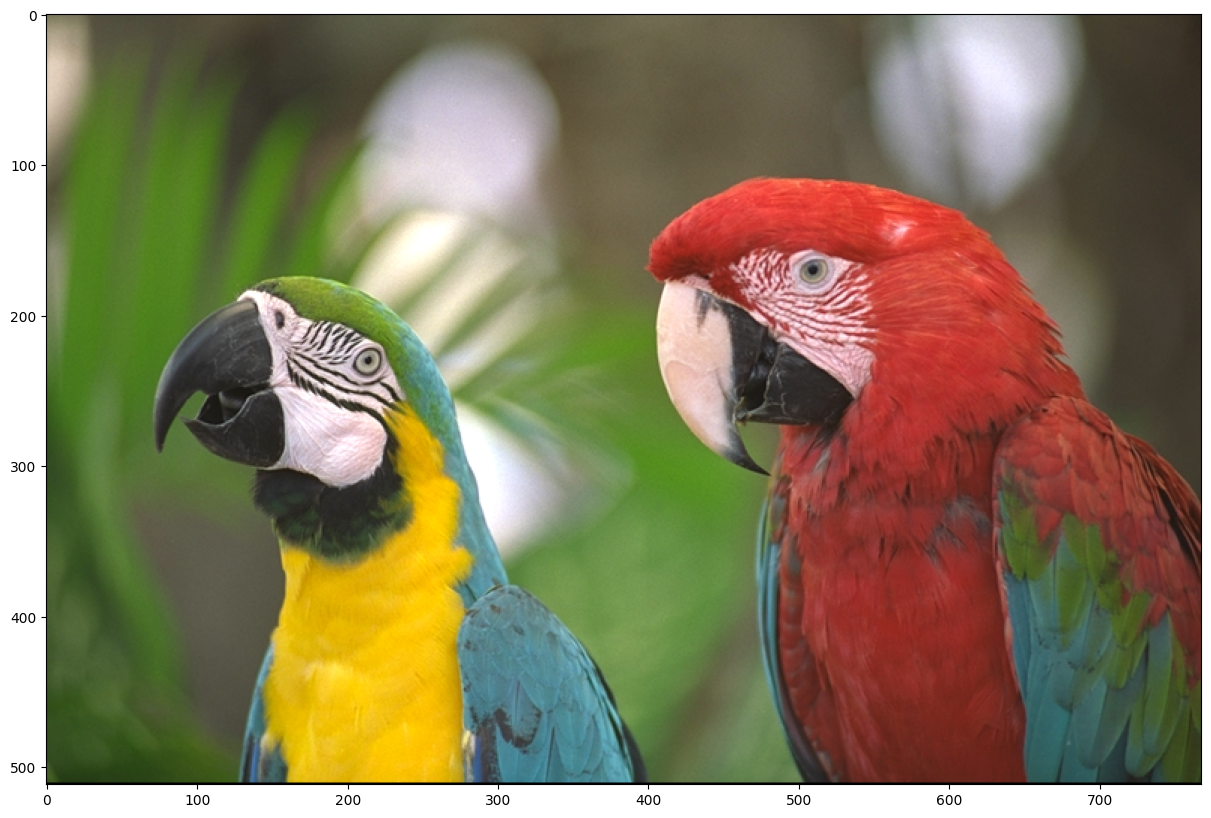

In [2]:
# Load image
img = cv2.imread('data/kodim23.png')
# Convert it to RGB
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# Plot it
plt.imshow(img)

Let's start with gray tones first.

In [3]:
# Black, dark gray, light gray, white
colors = np.array([[0, 0, 0],
                   [64, 64, 64],
                   [192, 192, 192],
                   [255, 255, 255]])

Using the colour pallette, let's quantize the original image.

In [4]:
# Cast the image to float
from tqdm.notebook import tqdm

def quantize(img, colors):
    img = img.astype(float)
    
    # Prepare for quantization
    rows, cols, channels = img.shape
    quantized = np.zeros_like(img)
    
    # Apply quantization
    for r in tqdm(range(rows)):
        for c in range(cols):
            # Extract the original pixel value
            pixel = img[r, c]
            
            # Find the closest colour from the pallette (using absolute value/Euclidean distance)
            # Note: You may need more than one line of code here
            diff_sq = 3*255**2
            new_pixel = np.array([255,255,255])
            for color in colors:
                potential_diff_sq = np.linalg.norm((pixel - color))
                if potential_diff_sq < diff_sq:
                    new_pixel = color
                    diff_sq = potential_diff_sq
            
            # Apply quantization
            quantized[r, c, :] = new_pixel
    return quantized

quantized = quantize(img, colors)

  0%|          | 0/512 [00:00<?, ?it/s]

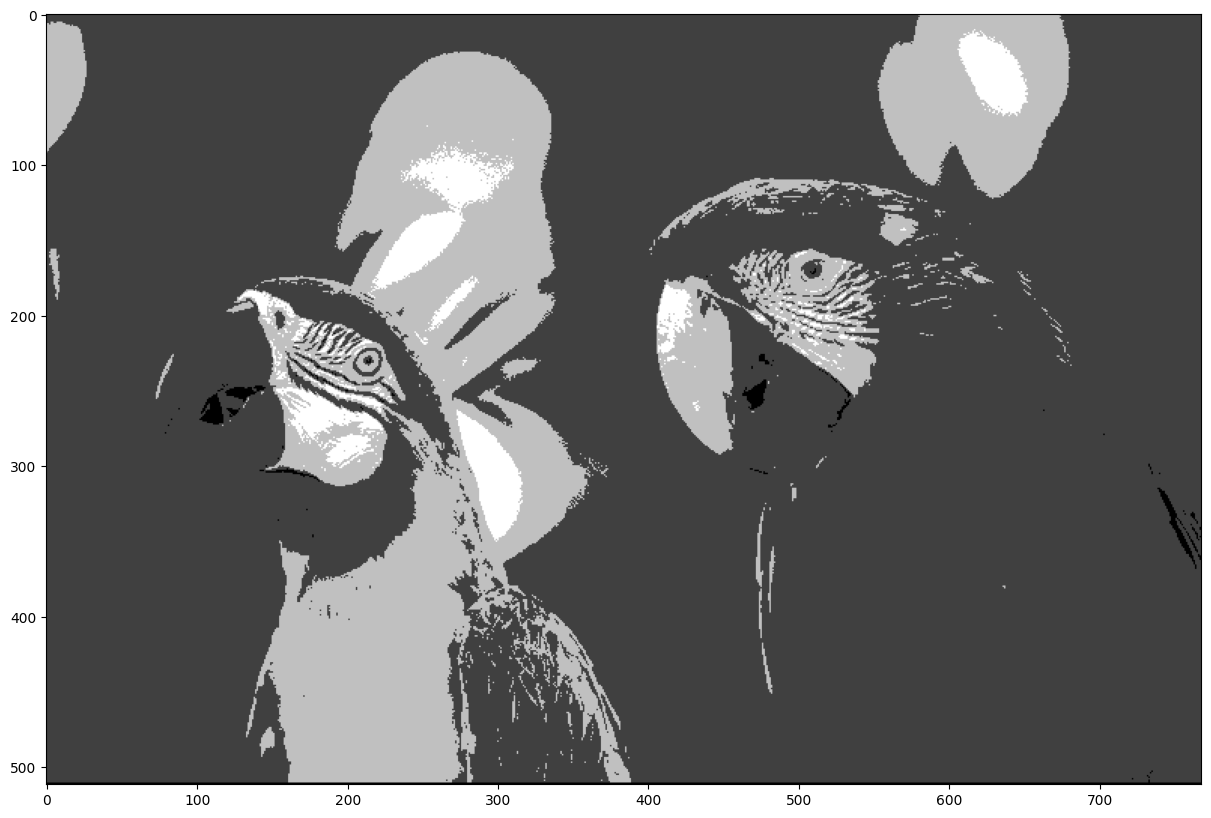

In [5]:
# Show quantized image (don't forget to cast back to uint8)
plt.imshow(quantized.astype(np.uint8))

In [6]:
# Compute average quantization error
avg_quant_error = np.mean((quantized - img)**2)
avg_quant_error

np.float64(2140.2978049384224)

#### Floyd-Steinberg Dithering
We are now going to implement the FS dithering and compare it to the optimally quantized image we have calculated above.

In [7]:
# Make a temporal copy of the original image, we will need it for error diffusion

def apply_dithering(img, colors):
    img_tmp = np.copy(img).astype(float)
    dithering = np.zeros_like(img)
    
    rows, cols, channels = img_tmp.shape

    
    for r in tqdm(range(1, rows-1)):
        for c in range(1, cols-1):
            # Extract the original pixel value
            pixel = img_tmp[r, c].copy()
            
            # Find the closest colour from the pallette (using absolute value/Euclidean distance)
            # Note: You may need more than one line of code here
            diff_sq = np.inf
            new_pixel = np.array([255,255,255])
            for color in colors:
                potential_diff_sq = np.linalg.norm((pixel - color))**2
                if potential_diff_sq < diff_sq:
                    new_pixel = color
                    diff_sq = potential_diff_sq        
            
            # Compute quantization error
            quant_error = pixel - new_pixel
            
            # Diffuse the quantization error accroding to the FS diffusion matrix
            # Note: You may need more than one line of code here
            img_tmp[r, c+1, :]  += 7*quant_error/16
            img_tmp[r+1, c-1, :] += 3*quant_error/16
            img_tmp[r+1, c, :]  += 5*quant_error/16
            img_tmp[r+1, c+1, :] += 1*quant_error/16

            dithering[r, c, :] = new_pixel
    img_tmp = np.clip(img_tmp, 0, 255)
    return dithering


  0%|          | 0/510 [00:00<?, ?it/s]

(<Axes: >, <matplotlib.image.AxesImage at 0x225832a40b0>)

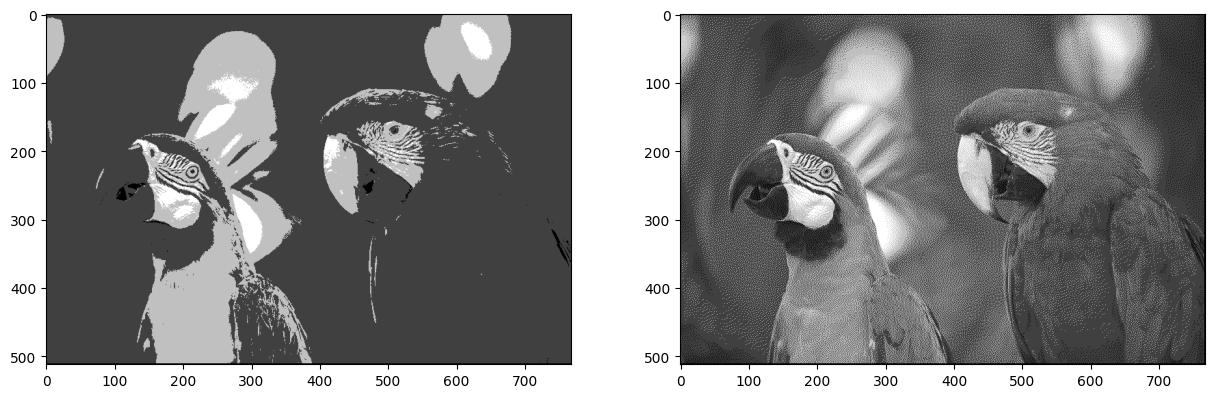

In [8]:
# Show quantized image (don't forget to cast back to uint8)
dithering = apply_dithering(img, colors)


plt.subplot(221), plt.imshow(quantized.astype(np.uint8))   # optimally quantized
plt.subplot(222), plt.imshow(dithering.astype(np.uint8))   # dithering

In [9]:
# Compute average quantization error for dithered image
avg_dith_error = np.mean((dithering - img)**2)
print(f"Dithering error = {avg_dith_error}")
print(f"Optimal quantization error = {avg_quant_error}")

Dithering error = 99.5255610148112
Optimal quantization error = 2140.2978049384224


### Questions
* Which image has higher quantization error? Optimally quantized or dithered?
* Which image looks better to you?
* Can you repeat the same process using only two colours: black and white? Show me :-)

## Answers
* Dithered image has higher quantization error
* At the same time, dithered image looks better

## The same dithering, but in black and white:

  0%|          | 0/512 [00:00<?, ?it/s]

  0%|          | 0/510 [00:00<?, ?it/s]

(<Axes: >, <matplotlib.image.AxesImage at 0x22583357230>)

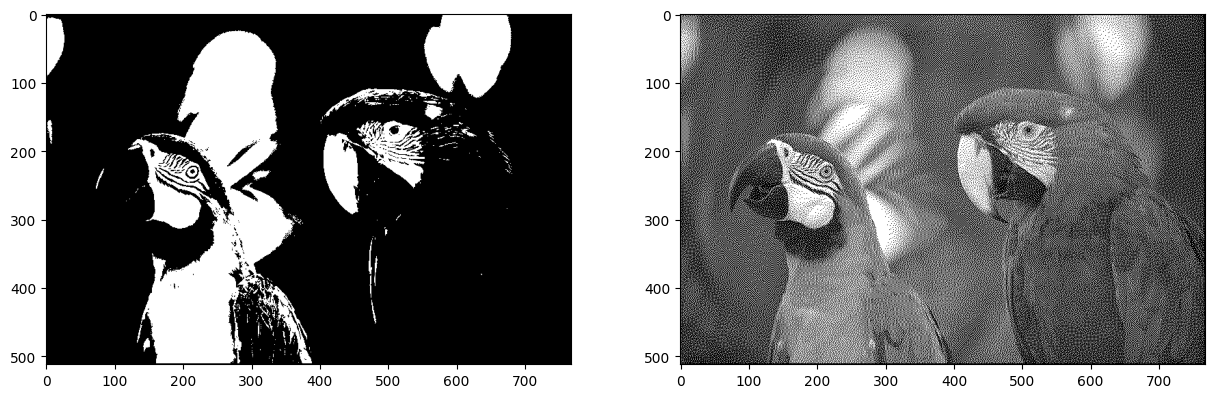

In [10]:
colors = np.array([[0, 0, 0],
                   [255, 255, 255]])
quantized_bw = quantize(img, colors)
dithered_bw  = apply_dithering(img, colors)

plt.subplot(221), plt.imshow(quantized_bw.astype(np.uint8))   # optimally quantized
plt.subplot(222), plt.imshow(dithered_bw.astype(np.uint8))   # dithering

**This looked too good to be true, so I checked it with counter**

In [11]:
from collections import Counter
pixels = np.reshape(dithered_bw, (-1, 3))
pixels = [tuple(p) for p in pixels]

colors = Counter(pixels)
colors

Counter({(np.uint8(0), np.uint8(0), np.uint8(0)): 236063,
         (np.uint8(255), np.uint8(255), np.uint8(255)): 157153})

**Wow, all correct and result looks even better than I thought :)**

### Bonus Points

Repeat the homework using a diffrerent image pallette. For instance, you can use an optimal colour
pallette that we can calculate via k-means algorithm. The following snippet of code will give you the 16
optimal colours for your original image.

In [12]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=16).fit(np.reshape(img, (-1, 3)))
colors = kmeans.cluster_centers_
print(colors)

C:\Users\gevor\.conda\envs\ComputerVision\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\gevor\.conda\envs\ComputerVision\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


[[ 55.98695408  53.09358926  41.292785  ]
 [153.15309515 151.81478599 133.73894588]
 [ 99.27887049  95.53824674  71.2887834 ]
 [241.71161664 231.8037367  234.24357755]
 [235.48690396 187.98810323  11.25846685]
 [208.11625015  69.24653559  58.9836551 ]
 [113.22362608  45.45918494  37.30983938]
 [183.04485084 174.35352201 168.865517  ]
 [110.16123493 141.31549141  71.4096456 ]
 [217.65017773 200.57446682 200.11220379]
 [153.32190042  55.21477202  48.08526847]
 [ 89.80882965 141.27638484 148.45381091]
 [ 72.68280031  83.78689701  49.30971955]
 [ 85.43276977 123.2245336   41.45847467]
 [125.97081061 128.35529251 102.7342588 ]
 [ 63.06487401  97.63698759  95.76833396]]


this is some typical warning for sklearn on windows which I will ignore :)

  0%|          | 0/512 [00:00<?, ?it/s]

  0%|          | 0/510 [00:00<?, ?it/s]

(<Axes: >, <matplotlib.image.AxesImage at 0x225a670e9f0>)

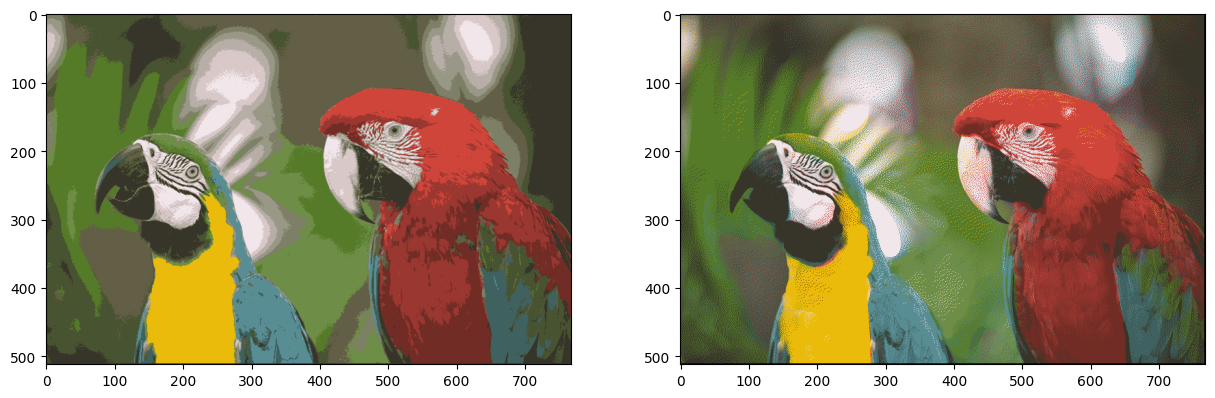

In [13]:
quantized_kmeans16 = quantize(img, colors)
dithered_kmeans16  = apply_dithering(img, colors)

plt.subplot(221), plt.imshow(quantized_kmeans16.astype(np.uint8))   # optimally quantized
plt.subplot(222), plt.imshow(dithered_kmeans16.astype(np.uint8))   # dithering

Lets increase the number of colors

  0%|          | 0/512 [00:00<?, ?it/s]

  0%|          | 0/510 [00:00<?, ?it/s]

(<Axes: >, <matplotlib.image.AxesImage at 0x225a57cb3e0>)

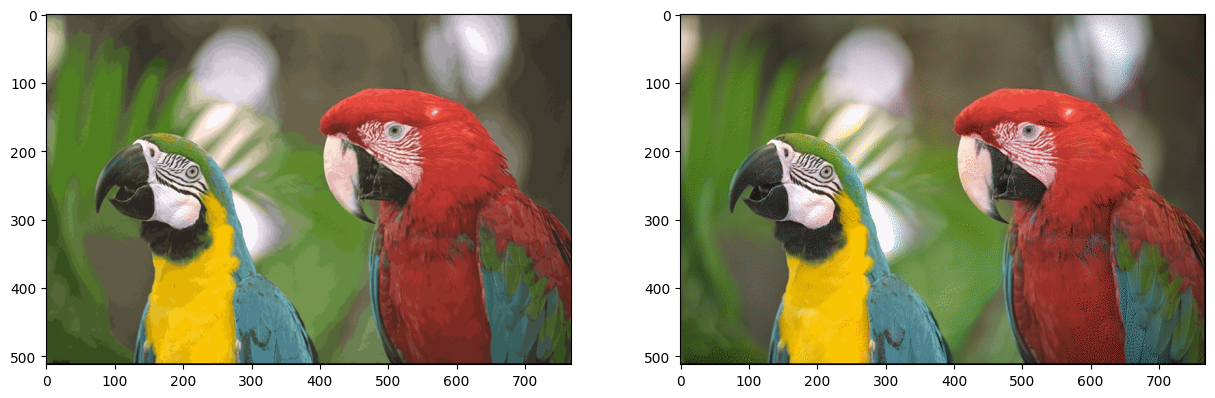

In [14]:
kmeans = KMeans(n_clusters=64).fit(np.reshape(img, (-1, 3)))
colors = kmeans.cluster_centers_

quantized_kmeans64 = quantize(img, colors)
dithered_kmeans64  = apply_dithering(img, colors)

plt.subplot(221), plt.imshow(quantized_kmeans64.astype(np.uint8))   # optimally quantized
plt.subplot(222), plt.imshow(dithered_kmeans64.astype(np.uint8))   # dithering

Apply FS dithering the same way you did before.
* How does the result look like to you?
* What happens if we use 32 colours?
* And what happens if we use 256 colours?

## Answers
* Looks nice
* The more colours the better (trade off between quality and compressing strength)
* At 64 colors the only clear loss of quality is yellow part, which had specific structure in the original picture